In [1]:
import os
os.chdir('/home/berling/reduce_opto_response/')
import pandas as pd
import numpy as np
import re
import pickle
import ast
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
from neuron import h
from neurostim.cell import Cell
from neurostim import models

--No graphics will be displayed.



              -- N E S T --
  Copyright (C) 2004 The NEST Initiative

 Version: 3.6.0
 Built: Jan  9 2025 17:16:28

 This program is provided AS IS and comes with
 NO WARRANTY. See the file LICENSE for details.

 Problems or suggestions?
   Visit https://www.nest-simulator.org

 Type 'nest.help()' to find out more about NEST.

Ca_HVA: gbar_Ca_HVA_somatic = 374.0 uS/cm^2, e_Ca_HVA = 132.4579341637009 mV
Ca_HVA: gbar_Ca_HVA_axonal = 306.0 uS/cm^2, e_Ca_HVA = 132.4579341637009 mV
Ca_HVA: gbar_Ca_HVA_basal = None uS/cm^2, e_Ca_HVA = 132.4579341637009 mV
Ca_HVA: gbar_Ca_HVA_apical = None uS/cm^2, e_Ca_HVA = 132.4579341637009 mV
Ca_LVAst: gbar_Ca_LVAst_somatic = 778.0 uS/cm^2, e_Ca_LVAst = 132.4579341637009 mV
Ca_LVAst: gbar_Ca_LVAst_axonal = 50.0 uS/cm^2, e_Ca_LVAst = 132.4579341637009 mV
Ca_LVAst: gbar_Ca_LVAst_basal = None uS/cm^2, e_Ca_LVAst = 132.4579341637009 mV
Ca_LVAst: gbar_Ca_LVAst_apical = None uS/cm^2, e_Ca_LVAst = 132.4579341637009 mV
Ih: gbar_Ih_somatic = 80.0 uS/cm^2, e_Ih = 

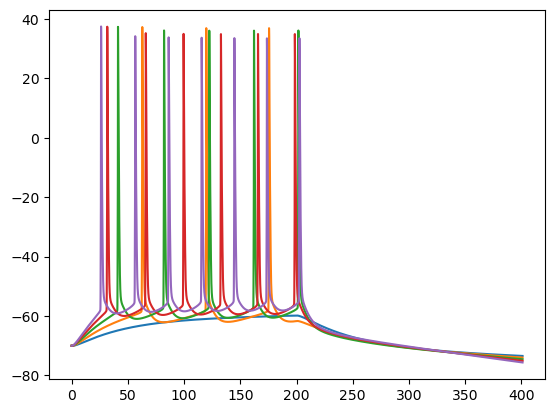

In [2]:
# load pre-simulated spatial activation maps
df = pd.read_csv('snake_workflow/result--L23_PC_cADpyr229_1_d50_NA0.1.csv', index_col='Unnamed: 0')
df_full = df.loc[(df.simtype=='full')]
df_RON_full = df.loc[(df.simtype=='RON_full')]
df_RON_adex = df.loc[(df.simtype=='RON_adex')]
merge = df_RON_full.merge(df_RON_adex, on=['patt_id','norm_power_mW_of_MultiStimulator', 'cond_scale_factor'])
merge = merge.loc[merge.patt_id==230]

def process_directory(directory):
    # Pattern with capture groups for patt_id and norm_power
    pattern = re.compile(
        r'slp-id230-xymax_110-dxy_10-norm_power_(?P<norm_power>[0-9eE\.-]+)-cluster_50-cond_scale_fct0\.85\.npy$'
    )

    results = []
    conds = dict()
    for filename in os.listdir(directory):
        match = pattern.match(filename)
        if match:
            file_path = os.path.join(directory, filename)
            try:
                array = np.load(file_path)
                if array.shape == (1, 250):
                    array_sum = array.sum()
                    norm_power = float(match.group('norm_power'))
                    conds[norm_power] = array[0]
                    results.append({
                        'cond': array_sum,
                        'norm_power': norm_power
                    })
                else:
                    print(f"Skipping {filename}: incorrect shape {array.shape}")
            except Exception as e:
                print(f"Error loading {filename}: {e}")

    df = pd.DataFrame(results)
    return df, conds
df, conds = process_directory('snake_workflow/simulated_data/RON_cond/L23_PC_cADpyr229_1/')
df = df.rename(columns=dict(norm_power='norm_power_mW_of_MultiStimulator'))
cond_merge = merge.merge(df, on=['norm_power_mW_of_MultiStimulator'])

time_ms = np.arange(0,250)
conductance_nS = conds[list(conds.keys())[0]]
##########################################################


# set up neuron model
cellmodel = getattr(models, 'L23_PC_cADpyr229_1')
cell = Cell(
    model=cellmodel(),
    ChR_soma_density=13e9,
    ChR_distribution='uniform'
)
# insert new conductance to 'inject' conductance
soma = cell.sections[0]
soma.insert('g_chanrhod')

# Define recording variables
rec_vars = [[],[]]
# append time and soma voltage recoding
# rec variables
rec_time = h.Vector().record(h._ref_t)
rec_v = h.Vector().record(soma(0.5)._ref_v)

def neuron_sim(time_ms, conductance_nS):
    # driving stimulus
    t = h.Vector(time_ms)
    y = h.Vector(conductance_nS*(100/soma(0.5).area())) # needs to be rescaled as gcat is density mechanism
    
    # run simulation with injected conductance
    h.load_file('stdrun.hoc')
    
    # play the stimulus into soma(0.5)'s ina
    # the last True means to interpolate; it's not the default, but unless
    # you know what you're doing, you probably want to pass True there
    y.play(soma(0.5)._ref_gcat2_g_chanrhod, t, True)
    
    # h.v_init, h.tstop= -70, temp_protocol['total_rec_time_ms']
    h.v_init, h.tstop= -70, 401
    h.run()
    
    # measure APC
    x = np.array(rec_time)
    y = np.array(rec_v)
    peaks, properties = find_peaks(y, height=-20, prominence=10)
    return x, y, peaks

APCs = []
cond_scales = np.arange(0.4,1.4,0.2)
for cond_scale in cond_scales:
    times, Vm, spike_times = neuron_sim(time_ms, conductance_nS*cond_scale)
    APCs.append(len(spike_times))
    plt.plot(times, Vm)

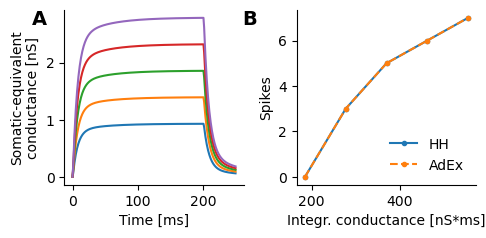

In [4]:
# organize data for plot
nest_cond_scales, nest_APCs = np.load('test_adex_fit.npy')
assert np.all(cond_scales==nest_cond_scales)
int_cond = []
cond_over_time = []
APC_HH = APCs
APC_AdEx = nest_APCs
for cond_scale in cond_scales:
    cond_over_time.append(cond_scale*conductance_nS)
    int_cond.append(np.sum(cond_scale*conductance_nS))

# plot
# figure format
a4_w = 8.27
a4_l = 11.7
fig, [ax1,ax2] = plt.subplots(ncols=2, figsize=(a4_w*0.6, a4_w*0.3))

for conductances in cond_over_time:
    ax1.plot(time_ms, conductances)
ax1.set_xlabel('Time [ms]')
ax1.set_ylabel('Somatic-equivalent\nconductance [nS]')

ax2.plot(int_cond, APC_HH,   marker='.', ls='solid', label='HH')
ax2.plot(int_cond, APC_AdEx, marker='.', ls='dashed', label='AdEx')
ax2.set_xlabel('Integr. conductance [nS*ms]')
ax2.set_ylabel('Spikes')
ax2.legend(frameon=False)

for ax in [ax1, ax2]:
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)

os.chdir('/home/berling/reduce_opto_response/article_figures/')
from article_plot_functions import label_subplots_ABC
label_subplots_ABC(fig, axs=[ax1, ax2], x_shift=-0.05, y_shift=0, fontsize=14, weight='bold')

plt.tight_layout()
fig.savefig('/home/berling/reduce_opto_response/article_figures/figures/newfit_adex_to_HH_L23_PC_1.png', facecolor='white', dpi=300)